In [22]:
!pip install numpy matplotlib ursina tqdm imageio scipy


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm
from abc import ABC, abstractmethod
import imageio
import os
from IPython.display import HTML, display
from io import BytesIO
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

# ======================
# Core System Components
# ======================

class Plant(ABC):
    def __init__(self, initial_state, dt):
        self.state = np.array(initial_state, dtype=np.float64)
        self.dt = dt

    @abstractmethod
    def step(self, action):
        pass

class Ecosystem(Plant):
    def __init__(self, initial_state, dt, params):
        super().__init__(initial_state, dt)
        # System parameters
        self.k = params.get('k', 0.01)      # Food influx rate
        self.α = params.get('α', 0.02)     # Food consumption by prey
        self.β = params.get('β', 0.001)     # Prey growth efficiency
        self.γ = params.get('γ', 0.1)      # Predation rate on prey
        self.δ = params.get('δ', 0.005)     # Predator growth efficiency
        self.μ = params.get('μ', 0.1)      # Predator death rate

    def system_dynamics(self, state, action):
        f, p, r = state[:3]  # Food, prey, predators
        u1, u2, u3 = action  # Control inputs
        
        # Food dynamics: df/dt = k*f - α*p + u1
        df = self.k * f - self.α * p + u1
        
        # Prey dynamics: dp/dt = β*f*p - γ*r + u2
        dp = self.β * f * p - self.γ * r + u2
        
        # Predator dynamics: dr/dt = δ*p*r - μ*r + u3
        dr = self.δ * p * r - self.μ * r + u3
        
        return np.array([df, dp, dr])

    def step(self, action):
        derivative = self.system_dynamics(self.state, action)
        self.state[:3] += derivative * self.dt
        self.state[:3] = np.clip(self.state[:3], a_min=0, a_max=None)
        #self.state[3:] = derivative  # Store derivatives as state variables
        return self.state.copy()

class Controller(ABC):
    @abstractmethod
    def get_action(self, state):
        pass


class EnergyController(Controller):
    def __init__(self, target_state, params, Q=np.diag([1, 1, 1]), R=np.diag([0.1, 0.1, 0.1])):
        self.target = np.array(target_state[:3])  # Target [f, p, r]
        self.Q = Q  # State cost matrix
        self.R = R  # Control effort matrix
        # System parameters
        self.k = params.get('k', 0.1)      # Food influx rate
        self.α = params.get('α', 0.02)     # Food consumption by prey
        self.β = params.get('β', 0.01)     # Prey growth efficiency
        self.γ = params.get('γ', 0.1)      # Predation rate on prey
        self.δ = params.get('δ', 0.05)     # Predator growth efficiency
        self.μ = params.get('μ', 0.1)      # Predator death rate

    def lyapunov_function(self, state):
        error = state[:3] - self.target
        return error.T @ self.Q @ error

    def get_action(self, state, target):
        f, p, r = state[:3]  # Current food, prey, predators
        f_goal, p_goal, r_goal = state[:3] - target[:3]
        
        # Control components from the image
        a1 = -f * self.k + p * self.α - f_goal * self.k
        a2 = -p * f * self.β + r * self.γ - p_goal * self.β
        a3 = -r * p * self.δ + r * self.μ - r_goal * self.μ
        
        # Construct control action with stability conditions
        action = np.array([a1, a2, a3])
        
        # Apply stability constraints (0₁ ≤ 0, 0₂ ≤ 0, 0₃ ≤ 0)
        #action = np.minimum(action, 0)  # Ensures all components ≤ 0
        
        # Scale and clip the action for realistic implementation
        #action = np.clip(action, -5, 0)  # Only allow negative (stabilizing) actions
        
        return action
        '''
        f, p, r = state[:3]
        error = state[:3] - self.target
        
        # Control law derived from Lyapunov stability analysis
        u = -np.array([
            self.k * f - self.α * p,       # Food control
            self.β * f * p - self.γ * r,   # Prey control
            self.δ * p * r - self.μ * r    # Predator control
        ]) - 0.5 * self.Q @ error
        
        # Add damping through control effort penalty
        u = -np.linalg.inv(self.R) @ u
        
        return np.clip(u, -5, 5)  # Constrain control inputs
        '''

# ======================
# Simulation Framework
# ======================

class Simulation:
    def __init__(self, plant, controller):
        self.plant = plant
        self.controller = controller
        self.states = []
        self.actions = []
    
    def run(self, total_time):
        steps = int(total_time / self.plant.dt)
        self.states = [self.plant.state.copy()]
        self.actions = []
        
        for _ in tqdm(range(steps)):
            action = self.controller.get_action(self.plant.state, self.controller.target)
            new_state = self.plant.step(action)
            #print(new_state)
            
            self.actions.append(action)
            self.states.append(new_state.copy())

        self.states = np.array(self.states)    
        self.actions = np.array(self.actions)    
        return np.array(self.states), np.array(self.actions)

# ======================
# Visualization
# ======================

class Animator:
    def __init__(self, simulation):
        self.simulation = simulation
        self.fig, self.ax = plt.subplots(3, 1, figsize=(10, 8))
        
    def animate(self):
        def update(frame):
            for ax in self.ax:
                ax.clear()
                
            t = np.linspace(0, self.simulation.plant.dt*frame, frame)
            
            # Plot populations
            self.ax[0].plot(t, self.simulation.states[:frame, 0], label='Food')
            self.ax[0].set_ylabel('Food')
            
            self.ax[1].plot(t, self.simulation.states[:frame, 1], label='Prey')
            self.ax[1].set_ylabel('Prey')
            
            self.ax[2].plot(t, self.simulation.states[:frame, 2], label='Predators')
            self.ax[2].set_ylabel('Predators')
            self.ax[2].set_xlabel('Time')
            
            for ax in self.ax:
                ax.legend()
                ax.grid(True)
                
            return self.ax
        
        anim = animation.FuncAnimation(
            self.fig, update, frames=len(self.simulation.states), interval=50)
        plt.close()
        return anim


class Animator_ImageIO:
    def __init__(self, simulation):
        self.simulation = simulation
        self.t_max = len(self.simulation.states) * self.simulation.plant.dt
        self.targets = self.simulation.controller.target[:3]  # [food, prey, predator]
        
    def create_frame(self, frame_idx):
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])
        
        # State subplots (left column)
        ax_state = [fig.add_subplot(gs[i, 0]) for i in range(3)]
        
        # Action subplots (right column)
        ax_action = [fig.add_subplot(gs[i, 1]) for i in range(3)]
        
        # Time vector
        t = np.linspace(0, self.t_max, len(self.simulation.states))
        current_t = frame_idx * self.simulation.plant.dt
        
        # Plot states (left column)
        for i, (label, color, target) in enumerate(zip(
            ['Food', 'Prey', 'Predators'], 
            ['blue', 'blue', 'blue'],
            self.targets
        )):
            # State trajectory
            ax_state[i].plot(t[:frame_idx], self.simulation.states[:frame_idx, i], 
                           color=color, label=label)
            
            # Current state marker
            if frame_idx > 0:
                ax_state[i].plot(current_t, self.simulation.states[frame_idx-1, i], 
                               'ro', markersize=8)
            
            # Target line
            ax_state[i].axhline(y=target, color='red', linestyle=':', linewidth=2,
                              label=f'Target {label}')
            
            ax_state[i].set_ylabel(f'{label} Population')
            ax_state[i].set_ylim(0, np.max(self.simulation.states[:, i])*1.1)
            ax_state[i].set_xlim(0, self.t_max)
            ax_state[i].legend(loc='upper right')
            ax_state[i].grid(True)
        
        ax_state[2].set_xlabel('Time')
        
        # Plot actions (right column)
        action_labels = ['Food Control', 'Prey Control', 'Predator Control']
        action_colors = ['green', 'green', 'green']
        
        for i in range(3):
            if frame_idx > 0:
                # Vertical bar plot
                current_action = self.simulation.actions[frame_idx-1, i]
                bar = ax_action[i].bar(0, current_action, color=action_colors[i], width=0.6)
                
                # Auto-scale y-axis with buffer
                action_range = max(1, np.max(np.abs(self.simulation.actions[:, i]))) * 1.2
                ax_action[i].set_ylim(-action_range, action_range)
                
                # Style adjustments
                ax_action[i].set_title(action_labels[i])
                ax_action[i].set_xticks([])
                ax_action[i].yaxis.set_major_locator(plt.MaxNLocator(5))
                ax_action[i].grid(True, axis='y')
                
                # Add value label at top/bottom of bar
                va = 'bottom' if current_action >= 0 else 'top'
                y_pos = current_action * 0.95 if current_action >= 0 else current_action * 1.05
                ax_action[i].text(0, y_pos, f'{current_action:.2f}',
                                 ha='center', va=va, color="black",
                                 fontweight='bold')
        
        plt.tight_layout()
        
        # Convert to image data
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        return image
        
    def animate(self, fps=30, skip_frames=1):
        # Create in-memory GIF writer
        gif_buffer = BytesIO()
        gif_buffer = "anim.gif"
        
        with imageio.get_writer(gif_buffer, mode='I', fps=fps) as writer:
            for i in tqdm(range(0, len(self.simulation.states), skip_frames)):
                frame = self.create_frame(i)
                writer.append_data(frame)
        
        writer.close()
        # Display in notebook
        #gif_buffer.seek(0)
        #display(HTML(f'<img src="data:image/gif;base64,{gif_buffer.getvalue().hex()}">'))

class Animator_ImageIO_Proc:
    def __init__(self, simulation, output_dir="animation_frames"):
        self.simulation = simulation
        self.t_max = len(self.simulation.states) * self.simulation.plant.dt
        self.targets = self.simulation.controller.target[:3]
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
    def create_and_save_frame(self, frame_idx):
        fig = plt.figure(figsize=(15, 10))
        gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])
        
        # State subplots
        ax_state = [fig.add_subplot(gs[i, 0]) for i in range(3)]
        
        # Action subplots
        ax_action = [fig.add_subplot(gs[i, 1]) for i in range(3)]
        
        t = np.linspace(0, self.t_max, len(self.simulation.states))
        current_t = frame_idx * self.simulation.plant.dt
        
        # Plot states
        for i, (label, color, target) in enumerate(zip(
            ['Food', 'Prey', 'Predators'], 
            ['blue', 'blue', 'blue'],
            self.targets
        )):
            ax_state[i].plot(t[:frame_idx], self.simulation.states[:frame_idx, i], 
                           color=color, label=label)
            
            if frame_idx > 0:
                ax_state[i].plot(current_t, self.simulation.states[frame_idx-1, i], 
                               'ro', markersize=8)
            
            ax_state[i].axhline(y=target, color='red', linestyle=':', linewidth=2,
                              label=f'Target {label}')
            
            ax_state[i].set_ylabel(f'{label} Population')
            ax_state[i].set_ylim(0, np.max(self.simulation.states[:, i])*1.1)
            ax_state[i].set_xlim(0, self.t_max)
            ax_state[i].legend(loc='upper right')
            ax_state[i].grid(True)
        
        ax_state[2].set_xlabel('Time')
        
        # Plot actions
        action_labels = ['Food Control', 'Prey Control', 'Predator Control']
        action_colors = ['green', 'green', 'green']
        
        for i in range(3):
            if frame_idx > 0:
                current_action = self.simulation.actions[frame_idx-1, i]
                bar = ax_action[i].bar(0, current_action, color=action_colors[i], width=0.6)
                
                action_range = max(1, np.max(np.abs(self.simulation.actions[:, i]))) * 1.2
                ax_action[i].set_ylim(-action_range, action_range)
                
                ax_action[i].set_title(action_labels[i])
                ax_action[i].set_xticks([])
                ax_action[i].yaxis.set_major_locator(plt.MaxNLocator(5))
                ax_action[i].grid(True, axis='y')
                
                va = 'bottom' if current_action >= 0 else 'top'
                y_pos = current_action * 0.95 if current_action >= 0 else current_action * 1.05
                ax_action[i].text(0, y_pos, f'{current_action:.2f}',
                                 ha='center', va=va, color="black",
                                 fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(f"{self.output_dir}/frame_{frame_idx:04d}.png", dpi=100)
        plt.close(fig)
        
    def generate_frames_parallel(self, skip_frames=1):
        frame_indices = range(0, len(self.simulation.states), skip_frames)
        with ProcessPoolExecutor() as executor:
            list(tqdm(executor.map(self.create_and_save_frame, frame_indices),
                 total=len(range(0, len(self.simulation.states), skip_frames))))
    
    def create_gif(self, fps=30, output_file="animation.gif"):
        frames = []
        frame_files = sorted([f for f in os.listdir(self.output_dir) if f.startswith('frame_')])
        
        for frame_file in tqdm(frame_files):
            frames.append(imageio.imread(os.path.join(self.output_dir, frame_file)))
        
        imageio.mimsave(output_file, frames, fps=fps)
        return output_file

    def animate(self, fps=30, skip_frames=1):
        # Step 1: Generate frames in parallel
        self.generate_frames_parallel(skip_frames)
        
        # Step 2: Create GIF from saved frames
        gif_path = self.create_gif(fps)
        
        # Display in notebook
        display(HTML(f'<img src="{gif_path}">'))
        return gif_path

# ======================
# Usage Example
# ======================

if __name__ == "__main__":
    # Initialize system
    params = {
    'k': 0.12,      # Food influx rate
    'α': 0.3,      # Food consumption by prey
    'β': 0.04,     # Prey growth efficiency
    'γ': 10,      # Predation rate on prey
    'δ': 0.08,      # Predator growth efficiency
    'μ': 3       # Predator death rate   

}
    '''
    'k': 0.01,      # Food influx rate
    'α': 0.1,      # Food consumption by prey
    'β': 0.005,     # Prey growth efficiency
    'γ': 1.5,      # Predation rate on prey
    'δ': 0.005,      # Predator growth efficiency
    'μ': 0.4       # Predator death rate   
    '''
    eco = Ecosystem(
        initial_state=[200, 90, 60],
        dt=0.1,
        params=params
    )

    # Set up controller
    target = [20, 30, 6]  # Desired equilibrium
    controller = EnergyController(
        target,
        params=params
        )

    # Run simulation
    sim = Simulation(eco, controller)
    states, actions = sim.run(total_time=60)

    #print(sim.states)
    # Visualize
    # animator = Animator_ImageIO_Proc(sim)
    # anim = animator.animate()
    #html = anim.to_html5_video()
    #HTML(html)

100%|██████████| 600/600 [00:00<00:00, 92135.26it/s]


In [33]:
start = 0
step = 0.1
num = len(states)
a = start + np.arange(num) * step 
a=a.astype(float).tolist()
States=states.astype(float).tolist()
Actions = actions.astype(float).tolist()


In [34]:
import json
data = {
    "time_points": a,
    "states": States,
    "controls": Actions
}

with open("simulations/phase_data_2.json", "w") as f:
    json.dump(data, f) 

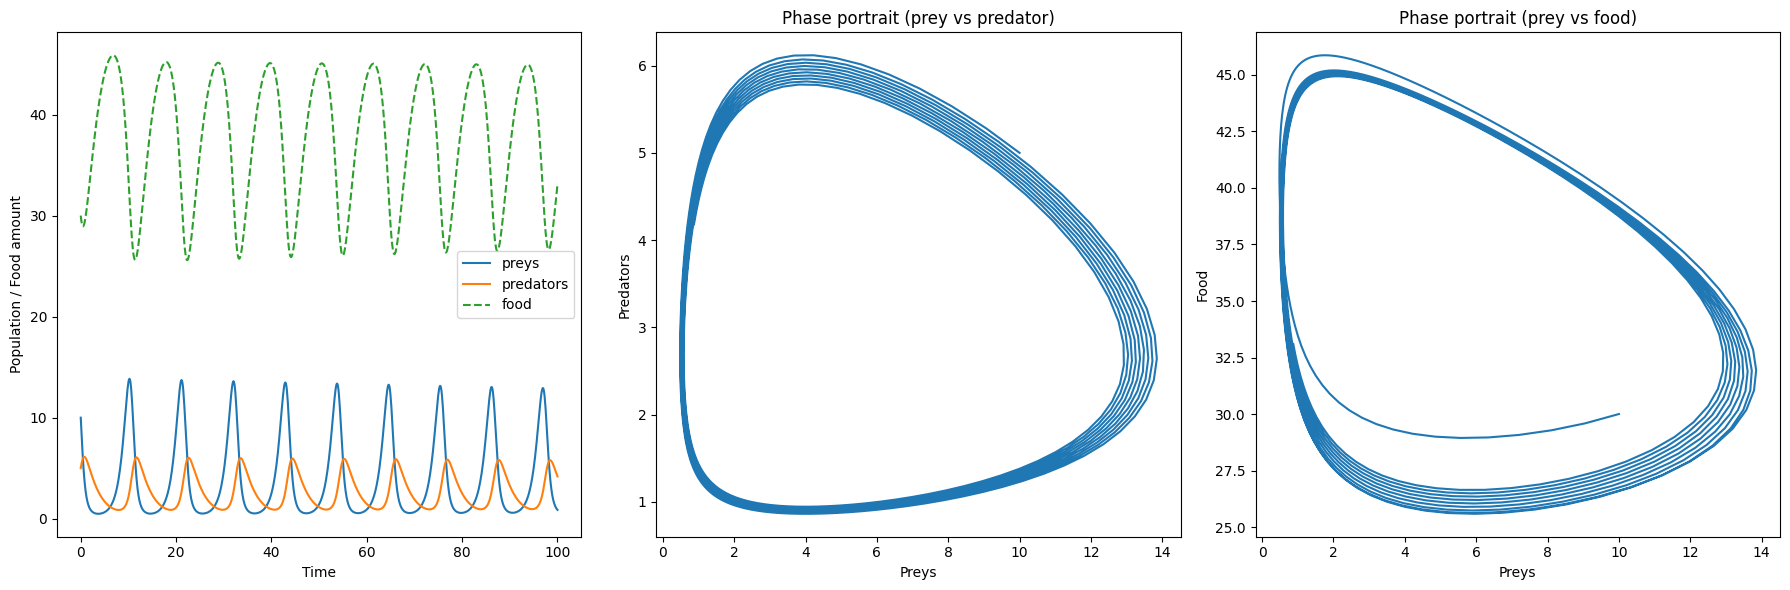

In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


alpha = 1.1   
beta = 0.4   
gamma = 0.4   
delta = 0.1   
r = 0.5       
K = 50        # Max food


def lotka_volterra_with_food(y, t):
    x, y_pred, food = y
    dxdt = alpha * x * (food / (food + 1)) - beta * x * y_pred
    dydt = delta * x * y_pred - gamma * y_pred
    dfooddt = r * food * (1 - food / K) - alpha * x * (food / (food + 1))
    return [dxdt, dydt, dfooddt]


y0 = [10, 5, 30]
t = np.linspace(0, 100, 1000)

solution = odeint(lotka_volterra_with_food, y0, t)
x, y_pred, food = solution.T


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1)
plt.plot(t, x, label='preys')
plt.plot(t, y_pred, label='predators')
plt.plot(t, food, label='food', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Population / Food amount')
plt.legend()

# Фазовый портрет (жертвы и хищники)
plt.subplot(1, 3, 2)
plt.plot(x, y_pred)
plt.xlabel('Preys')
plt.ylabel('Predators')
plt.title('Phase portrait (prey vs predator)')

# Фазовый портрет (жертвы и еда)
plt.subplot(1, 3, 3)
plt.plot(x, food)
plt.xlabel('Preys')
plt.ylabel('Food')
plt.title('Phase portrait (prey vs food)')

plt.tight_layout()
plt.show()


# Lyapunov-based Control of a Predator-Prey Ecosystem

---

## Problem Description

We simulate and control a simplified ecosystem using a dynamical systems framework. The ecosystem consists of three interacting populations:

- **Food (F)**: A renewable resource.  
- **Prey (P)**: Herbivores that consume food.  
- **Predators (R)**: Carnivores that consume prey.  

Our objective is to control this system using feedback such that the state $(F, P, R)$ converges to a desired target equilibrium.

---

## State Space Description

The system's state is described by the vector:

$$
x = \begin{bmatrix} f \\ p \\ r \end{bmatrix}
$$

Where:
- $f$: amount of food,
- $p$: number of prey,
- $r$: number of predators.

---

## Action Space Description

The control action vector $u \in \mathbb{R}^3$ is defined as:

$$
u = \begin{bmatrix} u_1 \\ u_2 \\ u_3 \end{bmatrix}
$$

Where:
- $u_1$: control input to influence food supply,
- $u_2$: control input to influence prey population,
- $u_3$: control input to influence predator population.

---

## System Dynamics

The dynamics are modeled as a set of nonlinear differential equations:

$$
\begin{aligned}
\frac{df}{dt} &= kf - \alpha p + u_1 \\
\frac{dp}{dt} &= \beta fp - \gamma r + u_2 \\
\frac{dr}{dt} &= \delta pr - \mu r + u_3 \\
\end{aligned}
$$

Where:
- $k$: food influx rate,
- $\alpha$: rate of food consumption by prey,
- $\beta$: prey growth efficiency due to food,
- $\gamma$: predation rate,
- $\delta$: predator growth efficiency due to prey,
- $\mu$: predator death rate.

---

## Lyapunov-Based Control

To stabilize the system to a desired target state $x^* = [f^*, p^*, r^*]^T$, we employ Lyapunov-based feedback control. The Lyapunov function is chosen as a quadratic energy function:

$$
V(x) = (x - x^*)^T Q (x - x^*)
$$

In our implementation, we use the **identity matrix** for $Q$, which simplifies the Lyapunov function to:

$$
V(x) = (f - f^*)^2 + (p - p^*)^2 + (r - r^*)^2
$$

---

### Properties of the Lyapunov Function

1. **Positive Semi-Definite**:  
   $$
   V(x) \geq 0 \quad \forall x
   $$
   with equality if and only if $x = x^*$.

2. **Time Derivative of the Lyapunov Function**:

   Let $e = x - x^*$. Then the derivative is:

   $$
   \dot{V}(x) = 2(f - f^*)\dot{f} + 2(p - p^*)\dot{p} + 2(r - r^*)\dot{r}
   $$

   The controller is designed so that $\dot{V}(x) \leq 0$, which ensures stability and convergence to the equilibrium point.

---

## Controller and Class Structure

The system is implemented using a modular, class-based structure with clear responsibilities:

---

### `Plant` and `Ecosystem`

- `Plant`: An abstract class defining the structure of a dynamical system.
- `Ecosystem`: Inherits from `Plant`. Implements the specific nonlinear dynamics:

```python
df = self.k * f - self.α * p + u1
dp = self.β * f * p - self.γ * r + u2
dr = self.δ * p * r - self.μ * r + u3
